In [1]:
n_signif <- function(result, ...) {
    UseMethod("n_signif", result)
}

n_signif.DESeqResults = function(result) {
    r = as.data.frame(result)
    nrow(r[r$padj<0.05 & !is.na(r$padj), ])
}

n_signif.LimmaResults = function(result) {
    nrow(result[result$adj.P.Val<0.05, ])
}

In [2]:
suppressPackageStartupMessages(library("DESeq2"));

deseq2 = function(counts, metadata, design, ref=NULL, ...) {
    dds <- suppressMessages(DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = design
    ))
    keep <- rowSums(counts(dds)) >= 10
    dds <- dds[keep, ]
    if (!is.null(ref)) {
        terms = all.vars(design)
        if (length(terms) != 1)
            stop()
        dds[[terms]] <- relevel(factor(dds[[terms]]), ref = ref)
    }
    dds <- suppressMessages(DESeq(dds))
    results(dds, ...)
}

In [3]:
library(limma)

limma_voom = function(counts, metadata, design, ref=NULL, contrast=NULL, normalization_method='RLE', plot=T) {
    dge <- edgeR::DGEList(counts=counts)

    if (!is.null(ref)) {
        terms = all.vars(design)
        if (length(terms) != 1)
            stop()
        metadata[[terms]] <- relevel(factor(metadata[[terms]]), ref = ref)
    }
    design = model.matrix(design, data=metadata)

    if (!is.null(contrast)) {
        colnames(design) = gsub(contrast[1], '', colnames(design))
    }
    keep <- edgeR::filterByExpr(dge, design)
    dge <- dge[keep,,keep.lib.sizes=FALSE]
    dge <- edgeR::calcNormFactors(dge, normalization_method)
    v <- voom(dge, design, plot = plot)
    fit <- lmFit(v, design)

    if (!is.null(contrast)) {
        contrast_specification = paste(
            contrast[2],
            contrast[3],
            sep='-'
        )

        contrast.matrix <- limma::makeContrasts(contrasts=contrast_specification, levels=design)
        fit <- limma::contrasts.fit(fit, contrast.matrix)
    }

    fit.de <- eBayes(fit, robust=TRUE)
    table = topTable(fit.de, n=Inf)
    class(table) = c('data.frame', 'LimmaResults')
    table
}


Attaching package: ‘limma’


The following object is masked from ‘package:DESeq2’:

    plotMA


The following object is masked from ‘package:BiocGenerics’:

    plotMA




## Pasilla

In [4]:
library("pasilla")
# copy paste from DESeq2 vinette
pasCts <- system.file("extdata", "pasilla_gene_counts.tsv", package="pasilla", mustWork=TRUE)
pasAnno <- system.file("extdata", "pasilla_sample_annotation.csv", package="pasilla", mustWork=TRUE)
cts <- as.matrix(read.csv(pasCts, sep="\t", row.names="gene_id"))
coldata <- read.csv(pasAnno, row.names=1)
coldata <- coldata[, c("condition", "type")]
rownames(coldata) <- sub("fb", "", rownames(coldata))
cts <- cts[, rownames(coldata)]

### DESeq2

In [5]:
deseq2_pasilla = deseq2(cts, coldata, ~ condition)
n_signif(deseq2_pasilla)

[1] 841

In [6]:
deseq2_pasilla = deseq2(cts, coldata, ~ condition, contrast=c('condition', 'treated', 'untreated'))
n_signif(deseq2_pasilla)

[1] 841

### Limma-voom

In [7]:
limma_pasilla = limma_voom(cts, coldata, ~ condition, plot=F)
print(n_signif(limma_pasilla))

Removing intercept from test coefficients



[1] 688


In [8]:
coldata

,condition,type
,<fct>,<fct>
treated1,treated,single-read
treated2,treated,paired-end
treated3,treated,paired-end
untreated1,untreated,single-read
untreated2,untreated,single-read
untreated3,untreated,paired-end
untreated4,untreated,paired-end


In [9]:
limma_pasilla = limma_voom(cts, coldata, ~ condition, plot=F, ref='untreated')#
#contrast=c('condition', 'treated', 'untreated'))
print(n_signif(limma_pasilla))

Removing intercept from test coefficients



[1] 688


## Tuberculosis

### DESeq2

In [10]:
raw_counts_matrix = read.csv('../../data/clean/rna/all_samples_counts.csv', row.names=1)
clinical = read.csv('../../data/clean/rna/clinical_data_ordered_to_match_rna_counts.csv', row.names=1)
rownames(clinical) = colnames(raw_counts_matrix)
clinical = clinical[, c('Meningitis', 'Meningitis_with_tuberculosis_status')]
clinical$Meningitis = as.factor(gsub(" ", ".", clinical$Meningitis))
clinical$Meningitis_with_tuberculosis_status = as.factor(gsub(" ", ".", clinical$Meningitis_with_tuberculosis_status))

In [11]:
# filtered/unfiltered = whether low expressed genes and samples with low library sizes were filtered out
# tb.separated/tb.joined = whether tuberculosis subgroups were considered separately or not

In [12]:
deseq2_unfiltered_tb.joined = deseq2(
    counts=round(raw_counts_matrix), clinical, ~ Meningitis,
    contrast=c('Meningitis', 'Tuberculosis', 'Cryptococcal')
);
n_signif(deseq2_unfiltered_tb.joined)

[1] 16

In [13]:
deseq2_unfiltered_tb.separated = deseq2(
    counts=round(raw_counts_matrix), clinical, ~ Meningitis_with_tuberculosis_status,
    ref='Cryptococcal', contrast=c('Meningitis_with_tuberculosis_status', 'Definite.tuberculosis', 'Cryptococcal')
);
n_signif(deseq2_unfiltered_tb.separated)

[1] 112

#### After filtering:

In [14]:
gene_filtered = raw_counts_matrix[rowMeans(raw_counts_matrix >= 1) >= 0.25, ]
sample_keep = colnames(gene_filtered)[colMeans(gene_filtered >= 1) >= 0.4]
filtered_counts = gene_filtered[, sample_keep]
filtered_clinical = clinical[sample_keep, ]
setdiff(colnames(raw_counts_matrix), colnames(filtered_counts))

[1] "X093.TMD" "X128.TMD" "X074.TMS" "X158.TMD" "X167.TMR" "X175.TMD" "X233.CM"

In [15]:
deseq2_filtered_tb.separated = deseq2(
    counts=round(filtered_counts), filtered_clinical,
    ~ Meningitis_with_tuberculosis_status,
    contrast=c('Meningitis_with_tuberculosis_status', 'Definite.tuberculosis', 'Cryptococcal')
)
n_signif(deseq2_filtered_tb.separated)

[1] 125

#### Limma-voom

Warning message in limma::makeContrasts(contrasts = contrast_specification, levels = design):
“Renaming (Intercept) to Intercept”
Warning message in limma::contrasts.fit(fit, contrast.matrix):
“row names of contrasts don't match col names of coefficients”


[1] 9


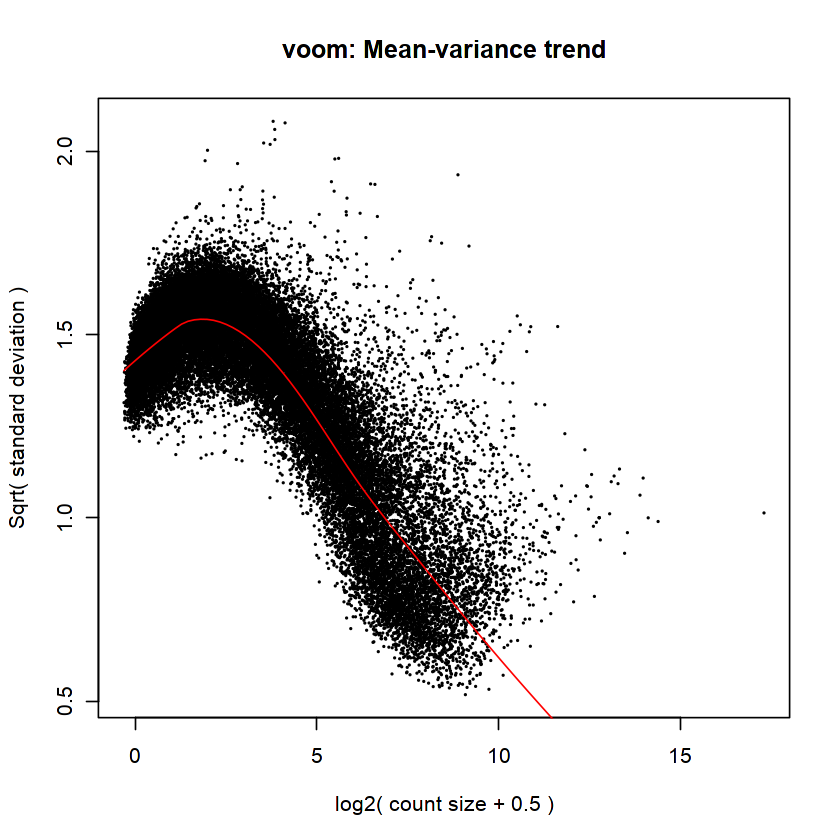

In [16]:
limma_filtered_tb.separated = limma_voom(
    counts=round(filtered_counts), filtered_clinical,
    ~ Meningitis_with_tuberculosis_status,
    contrast=c('Meningitis_with_tuberculosis_status', 'Definite.tuberculosis', 'Cryptococcal')
)
print(n_signif(limma_filtered_tb.separated))

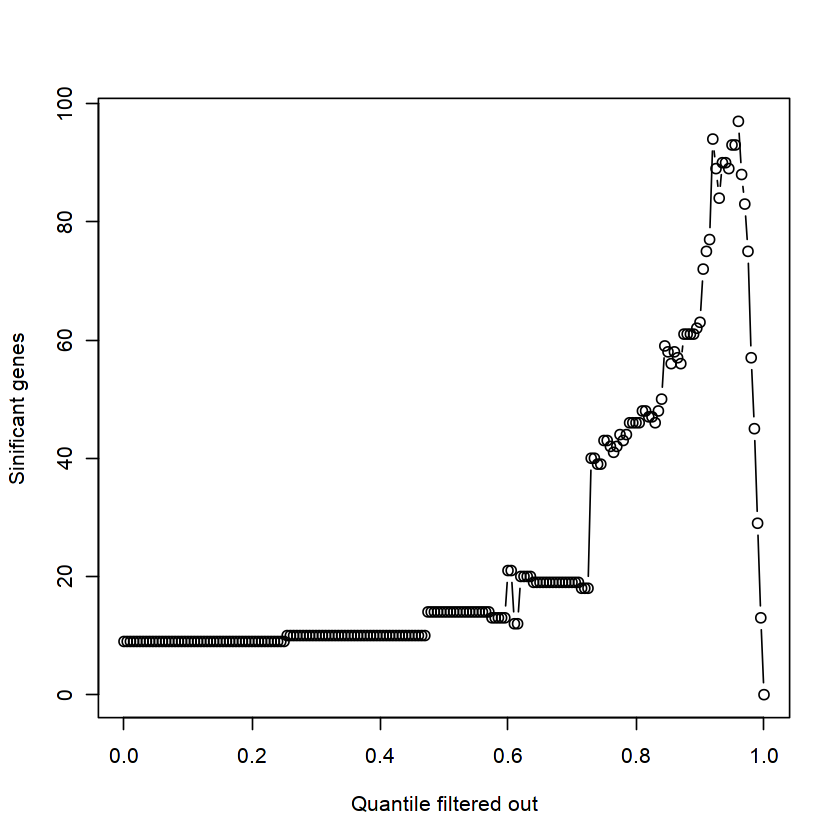

In [17]:
filter_by_mean_expresion = function(
    table, fdr_threshold=0.05, step=0.005, expression_col='AveExpr',
    pvalue_col='P.Value'
) {
    theta = seq(from=0.0, to=1, by=step)
    filtPadj <- genefilter::filtered_p(
        filter=table[, expression_col],
        test=table[, pvalue_col],
        theta=theta,
        method="BH"
    )
    numRej <- colSums(filtPadj < fdr_threshold, na.rm = TRUE)
    plot(theta, numRej, type="b", xlab="Quantile filtered out", ylab="Sinificant genes")
}
        
filter_by_mean_expresion(limma_filtered_tb.separated)

In [18]:
head(limma_filtered_tb.separated)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000274266,1.9654158,4.318199,5.554821,7.909462e-07,0.02181868,5.567510
ENSG00000100226,1.0060958,7.249812,5.250914,2.124837e-06,0.02181868,4.761307
ENSG00000164054,0.9358753,7.185182,5.249187,2.138491e-06,0.02181868,4.739342
ENSG00000117298,1.4894647,7.234489,5.327383,2.910744e-06,0.02181868,4.491898
ENSG00000173039,1.2427295,7.287450,5.245791,2.920606e-06,0.02181868,4.461024
ENSG00000089351,1.2829295,6.453927,4.992626,5.496113e-06,0.02932805,3.879580


In [19]:
sorted = function(data, by) {
    data = as.data.frame(data)
    data[order(data[by]), ]
}

In [20]:
head(sorted(deseq2_filtered_tb.separated, 'padj'))

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000100226,554.3110,1.168374,0.2173241,5.376183,7.608133e-08,0.0002553289
ENSG00000115956,2025.7888,2.061435,0.4551477,4.529156,5.921979e-06,0.0018067420
ENSG00000116514,410.4467,2.300974,0.4911298,4.685064,2.798727e-06,0.0018067420
ENSG00000117298,643.7829,1.494143,0.3293789,4.536245,5.726478e-06,0.0018067420
ENSG00000122729,265.8742,1.684353,0.3678897,4.578418,4.685053e-06,0.0018067420
ENSG00000128016,1919.0925,1.654466,0.3488701,4.742354,2.112494e-06,0.0018067420


## What when wrong with limma-voom?

This:

[1] 0


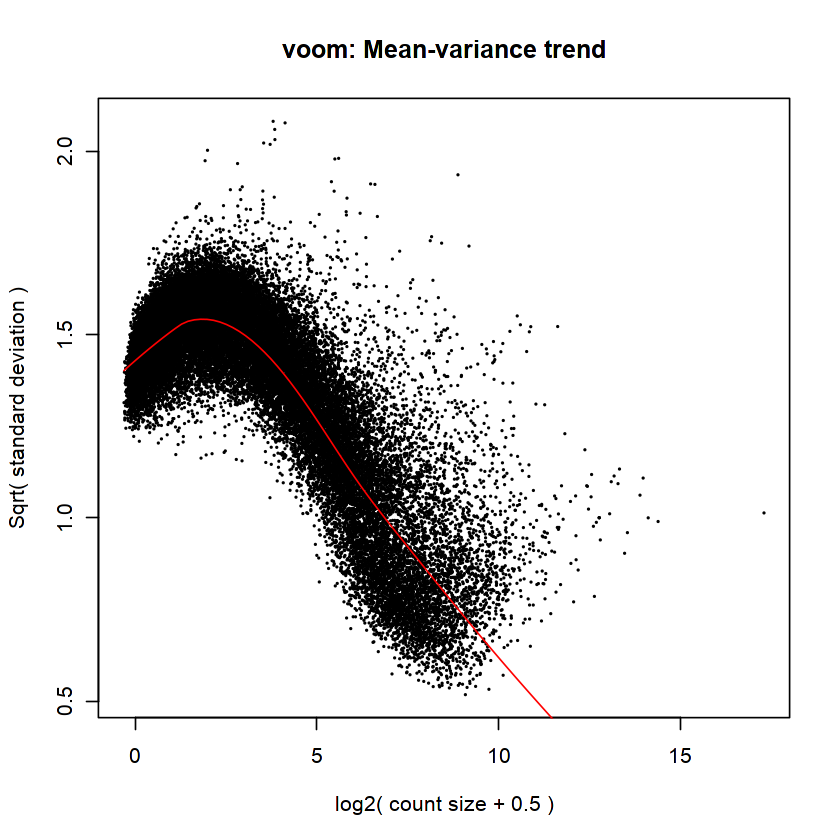

In [21]:
wrong_limma_filtered_tb.separated = limma_voom(
    counts=round(filtered_counts), filtered_clinical,
    # right here: 0 + variable. Why did I put 0 + here?
    ~ 0 + Meningitis_with_tuberculosis_status,
    contrast=c('Meningitis_with_tuberculosis_status', 'Definite.tuberculosis', 'Cryptococcal')
)
print(n_signif(wrong_limma_filtered_tb.separated))

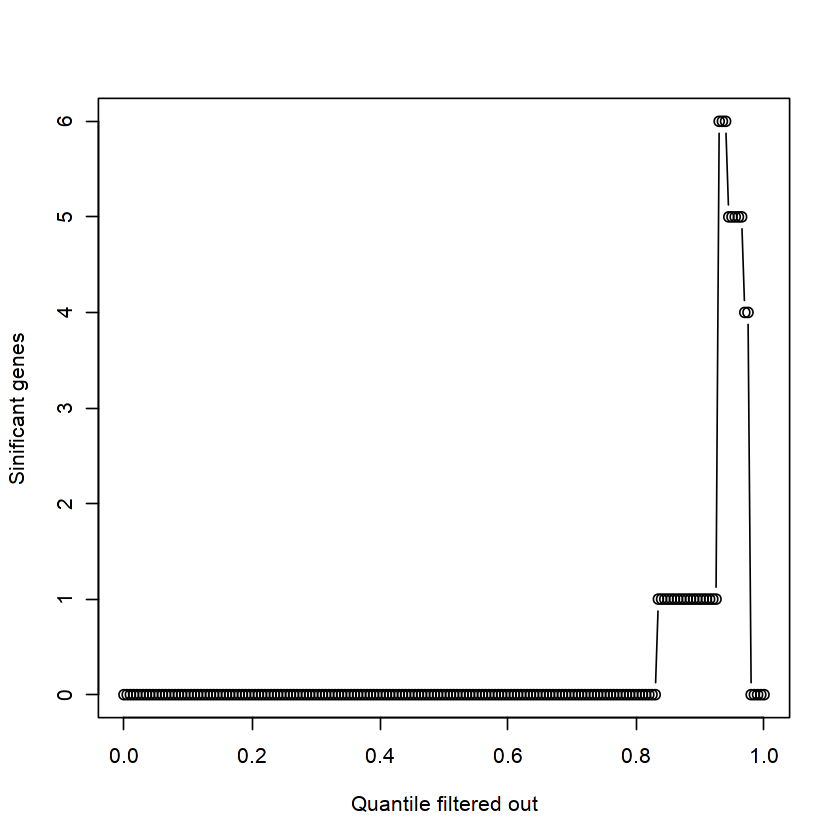

In [22]:
filter_by_mean_expresion(wrong_limma_filtered_tb.separated)